In [1]:
import torch
from transformers import BertModel, BertConfig
from py_auto_fact import auto_fact
from itertools import chain

# Init Model

In [2]:
config = BertConfig.from_pretrained('bert-base-uncased')
model = BertModel(config=config)
model = BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
layers = list(chain(*[[
    model.encoder.layer[i].attention.self.query,
    model.encoder.layer[i].attention.self.key,
    model.encoder.layer[i].attention.self.value,
    model.encoder.layer[i].attention.output.dense,
    model.encoder.layer[i].intermediate.dense,
    model.encoder.layer[i].output.dense
] for i in range(12)]))

In [4]:
mapping = {0: 'q', 1: 'k', 2:'v', 3:'o', 4:'ffn1', 5:'ffn2'}
z = []
for i,layer in enumerate(layers):
    _, x, _ = torch.svd(layer.weight)
    z.append(x)

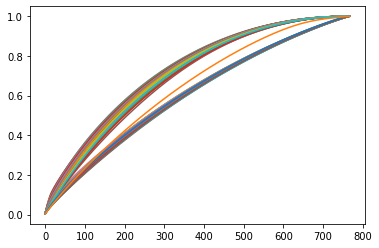

In [5]:
import matplotlib.pyplot as plt
for sv in z:
    plt.plot((sv / sv.sum()).sort(descending=True).values.cumsum(dim=0).detach().numpy())

# Factorize Model

In [8]:
%%time
fact_model = auto_fact(model, rank=256, deepcopy=True, solver='random', eigen_threshold=0.6)

cum_eigen_vals[rank] < eigen_threshold tensor(0.5890, grad_fn=<SelectBackward>) 0.6
cum_eigen_vals[rank] < eigen_threshold tensor(0.5943, grad_fn=<SelectBackward>) 0.6
CPU times: user 53.8 s, sys: 876 ms, total: 54.7 s
Wall time: 5.47 s


In [9]:
%%time
fact_model = auto_fact(model, rank=256, deepcopy=True, solver='svd', eigen_threshold=0.6)

CPU times: user 34.9 s, sys: 1.26 s, total: 36.2 s
Wall time: 3.96 s


In [10]:
%%time
fact_model = auto_fact(model, rank=256, deepcopy=True, solver='snmf', eigen_threshold=0.6)

CPU times: user 32 s, sys: 4.85 s, total: 36.8 s
Wall time: 4.22 s


In [11]:
%%time
fact_model = auto_fact(model, rank=256, deepcopy=True, solver='svd', num_iter=50, eigen_threshold=0.6)

CPU times: user 2min 18s, sys: 5.48 s, total: 2min 24s
Wall time: 14.7 s


In [12]:
%%time
fact_model = auto_fact(model, rank=256, deepcopy=True, solver='snmf', num_iter=50, eigen_threshold=0.6)

CPU times: user 2min 4s, sys: 5.88 s, total: 2min 10s
Wall time: 14.8 s


# Test on CPU

### Test Inference CPU

In [4]:
%%timeit
with torch.no_grad():
    y = model(torch.zeros(32,128, dtype=torch.long))

1.76 s ± 233 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
with torch.no_grad():
    y = fact_model(torch.zeros(32,128, dtype=torch.long))

854 ms ± 33.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Test Forward-Backward CPU

In [6]:
%%timeit
y = model(torch.zeros(8,128, dtype=torch.long))
y.last_hidden_state.sum().backward()

1.32 s ± 203 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
y = fact_model(torch.zeros(8,128, dtype=torch.long))
y.last_hidden_state.sum().backward()

599 ms ± 55.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test on GPU

### Move models to GPU

In [8]:
model = model.cuda()
fact_model = fact_model.cuda()

### Test Inference GPU

In [9]:
x = torch.zeros(32,128, dtype=torch.long).cuda()

In [10]:
%%timeit
with torch.no_grad():
    y = model(x)

113 ms ± 251 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
with torch.no_grad():
    y = fact_model(x)

61.3 ms ± 32.2 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Test Forward-Backward GPU

In [12]:
x = torch.zeros(8,128, dtype=torch.long).cuda()

In [13]:
%%timeit
y = model(x)
y.last_hidden_state.sum().backward()

92.3 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit
y = fact_model(x)
y.last_hidden_state.sum().backward()

58.1 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
